# Práctica 3: Segunda prueba

Importamos las librerías necesarias.

In [94]:
from collections import Counter
import pandas as pd
import numpy as np
from sklearn import preprocessing

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import SMOTE

### Funciones auxiliares

In [95]:
def grafica(data, label, title, xlab, ylab):
    plt.plot(data,label, c='b')
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)

    plt.show()

def graf_barras(data, label, title, xlab, ylab):
    fig, ax = plt.subplots()
    ax.bar(data, label, color='c')
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

## Lectura de datos

Leemos los datos:

In [96]:
datos = pd.read_csv("datos/train.csv", na_values=["?"])
test = pd.read_csv("datos/test.csv", na_values=["?"])

year = pd.read_csv("datos/ao.csv", na_values=["?"])
asientos = pd.read_csv("datos/asientos.csv", na_values=["?"])
ciudad = pd.read_csv("datos/ciudad.csv", na_values=["?"])
combustible = pd.read_csv("datos/combustible.csv", na_values=["?"])
consumo = pd.read_csv("datos/consumo.csv", na_values=["?"])
descuento = pd.read_csv("datos/descuento.csv", na_values=["?"])
kilometros = pd.read_csv("datos/kilometros.csv", na_values=["?"])
mano = pd.read_csv("datos/mano.csv", na_values=["?"])
motor_cc = pd.read_csv("datos/motor_cc.csv", na_values=["?"])
nombre = pd.read_csv("datos/nombre.csv", na_values=["?"])
potencia = pd.read_csv("datos/potencia.csv", na_values=["?"])
precio_cat = pd.read_csv("datos/precio_cat.csv", na_values=["?"])
tipo_marchas = pd.read_csv("datos/tipo_marchas.csv", na_values=["?"])

Identificamos las variables que tenemos así como la cantidad de datos nulos que hay.

In [97]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4819 entries, 0 to 4818
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            4747 non-null   float64
 1   Nombre        4747 non-null   object 
 2   Ciudad        4747 non-null   object 
 3   Año           4747 non-null   float64
 4   Kilometros    4747 non-null   float64
 5   Combustible   4747 non-null   object 
 6   Tipo_marchas  4747 non-null   object 
 7   Mano          4747 non-null   object 
 8   Consumo       4746 non-null   object 
 9   Motor_CC      4718 non-null   object 
 10  Potencia      4644 non-null   object 
 11  Asientos      4713 non-null   float64
 12  Descuento     659 non-null    float64
 13  Precio_cat    4819 non-null   int64  
dtypes: float64(5), int64(1), object(8)
memory usage: 527.2+ KB


In [98]:
# Total de valores perdidos que tenemos 
datos.isna().sum()

id                72
Nombre            72
Ciudad            72
Año               72
Kilometros        72
Combustible       72
Tipo_marchas      72
Mano              72
Consumo           73
Motor_CC         101
Potencia         175
Asientos         106
Descuento       4160
Precio_cat         0
dtype: int64

Vemos la distribución de los datos. No están balanceados.

[269, 602, 2211, 978, 759]


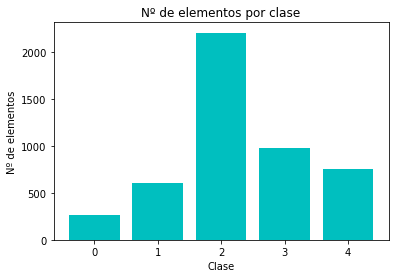

In [99]:
# Número de elementos por clase
m = [0 for i in range(5)]

for i in range(len(datos)):
    m[datos["Precio_cat"][i]-1]+=1
    
graf_barras(range(5), m, "Nº de elementos por clase","Clase","Nº de elementos")
print([m[i] for i in range(len(m))])

## Preprocesamiento

### Tratamiento de datos perdidos

Eliminamos la variable Descuento, que tiene muchos datos perdidos. Reindexamos y eliminamos la variable recien creada index. Eliminamos el resto de datos con valores perdidos.

In [100]:
p2_datos = datos.copy()
del(p2_datos['Descuento'])
p2_datos = p2_datos.dropna()
p2_datos = p2_datos.reset_index()
del(p2_datos['index'])
p2_datos

,id,Nombre,Ciudad,Año,Kilometros,Combustible,Tipo_marchas,Mano,Consumo,Motor_CC,Potencia,Asientos,Precio_cat
0,1.0,Maruti Swift Dzire ZDI,G,2012.0,83000.0,Diesel,Manual,First,23.4 kmpl,1248 CC,74 bhp,5.0,3
1,2.0,Maruti Wagon R LXI Optional,I,2016.0,4800.0,Petrol,Manual,First,20.51 kmpl,998 CC,67.04 bhp,5.0,3
2,3.0,Mahindra KUV 100 mFALCON D75 K8,F,2016.0,26000.0,Diesel,Manual,First,25.32 kmpl,1198 CC,77 bhp,6.0,3
3,4.0,Hyundai i20 1.2 Magna,E,2013.0,56127.0,Petrol,Manual,First,18.5 kmpl,1197 CC,80 bhp,5.0,3
4,5.0,Honda Jazz 1.2 SV i VTEC,H,2017.0,41981.0,Petrol,Manual,First,18.7 kmpl,1199 CC,88.7 bhp,5.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3941,4813.0,Audi A4 New 2.0 TDI Multitronic,J,2012.0,60000.0,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,4
3942,4814.0,Volkswagen Vento Petrol Highline,C,2012.0,67200.0,Petrol,Manual,First,15.04 kmpl,1598 CC,103.6 bhp,5.0,3
3943,4815.0,Maruti Swift VDI,E,2014.0,83274.0,Diesel,Manual,First,22.9 kmpl,1248 CC,74 bhp,5.0,3
3944,4818.0,Hyundai Xcent 1.2 VTVT S,E,2015.0,65743.0,Petrol,Manual,First,20.14 kmpl,1197 CC,81.86 bhp,5.0,3


### Paso de valores categóricas a numéricas

Nombre:

In [101]:
labelNombre = LabelEncoder().fit(nombre.Nombre)
p2_datos.Nombre = labelNombre.transform(p2_datos.Nombre)

Ciudad:

In [102]:
labelCiudad = LabelEncoder().fit(ciudad.Ciudad)
p2_datos.Ciudad = labelCiudad.transform(p2_datos.Ciudad)

Combustible:

In [103]:
labelCombustible = LabelEncoder().fit(combustible.Combustible)
p2_datos.Combustible = labelCombustible.transform(p2_datos.Combustible)

Tipo_marchas:

In [104]:
labelTipo_marchas = LabelEncoder().fit(tipo_marchas.Tipo_marchas)
p2_datos.Tipo_marchas = labelTipo_marchas.transform(p2_datos.Tipo_marchas)

Mano:

In [105]:
labelMano = LabelEncoder().fit(mano.Mano)
p2_datos.Mano = labelMano.transform(p2_datos.Mano)

Consumo:

In [106]:
for i in range(len(p2_datos)):
    p2_datos["Consumo"].iloc[i] = float(p2_datos["Consumo"].iloc[i].strip(' kmlp'))

/home/patricia/.local/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Motor_CC:

In [107]:
for i in range(len(p2_datos)):
    p2_datos["Motor_CC"].iloc[i] = float(p2_datos["Motor_CC"].iloc[i].strip(' CC'))

Potencia:

In [108]:
for i in range(len(p2_datos)):
    p2_datos["Potencia"].iloc[i]= float(p2_datos["Potencia"].iloc[i].strip(' bhp'))

## Separación de objetivo y etiqueta

In [109]:
# Separamos las columnas con los datos de la etiqueta a predecir
cols = [col for col in p2_datos.columns if col not in ['Precio_cat']]
data = p2_datos[cols]
del(data['id'])
target = p2_datos['Precio_cat']

## Aplicamos Oversampling

In [110]:
data, target = SMOTE(random_state=15).fit_resample(data, target)

In [111]:
Counter(target)

Counter({3: 1798, 2: 1798, 4: 1798, 5: 1798, 1: 1798})

## Selección de hiperparámetros

Criterio de división:

In [112]:
rf_clf = RandomForestClassifier(random_state=15, n_estimators=150)
score = cross_val_score(rf_clf, data, target, cv=5)

s = 0
for i in range(len(score)):
    s+= score[i]
    
print("La accuracy media es: " + str(s/len(score)))

La accuracy media es: 0.8972191323692993


In [113]:
rf_clf = RandomForestClassifier(random_state=15, n_estimators=150, criterion = "entropy")
score = cross_val_score(rf_clf, data, target, cv=5)

s = 0
for i in range(len(score)):
    s+= score[i]
    
print("La accuracy media es: " + str(s/len(score)))

La accuracy media es: 0.8997775305895438


Numero de estimadores:

In [114]:
# Vectores con los valores de las métricas
accuracy = []

for i in np.linspace(100, 300, num=9):
    print(i)
    rf_clf = RandomForestClassifier(random_state=15, n_estimators=int(i), criterion = "entropy")
    score = cross_val_score(rf_clf, data, target, cv=5)

    s = 0
    for i in range(len(score)):
        s+= score[i]
    accuracy.append(s/len(score))

100.0
125.0
150.0
175.0
200.0
225.0
250.0
275.0
300.0


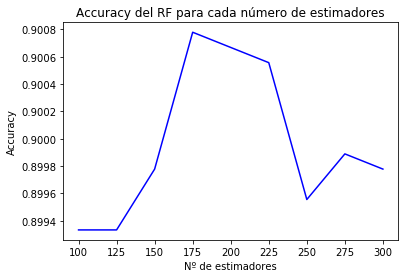

In [115]:
grafica(np.linspace(100, 300, num=9), accuracy, 'Accuracy del RF para cada número de estimadores', 'Nº de estimadores', 'Accuracy')

In [116]:
# Vectores con los valores de las métricas
accuracy = []

for i in np.linspace(150, 250, num=11):
    print(i)
    rf_clf = RandomForestClassifier(random_state=15, n_estimators=int(i), criterion = "entropy")
    score = cross_val_score(rf_clf, data, target, cv=5)

    s = 0
    for i in range(len(score)):
        s+= score[i]
    accuracy.append(s/len(score))

150.0
160.0
170.0
180.0
190.0
200.0
210.0
220.0
230.0
240.0
250.0


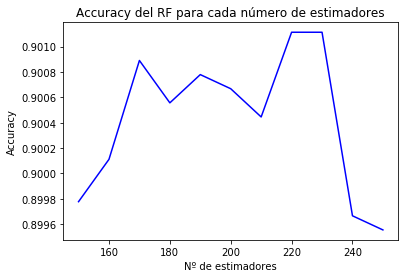

In [117]:
grafica(np.linspace(150, 250, num=11), accuracy, 'Accuracy del RF para cada número de estimadores', 'Nº de estimadores', 'Accuracy')

In [118]:
accuracy

[0.8997775305895438,
 0.9001112347052281,
 0.9008898776418242,
 0.9005561735261403,
 0.9007786429365963,
 0.9006674082313681,
 0.9004449388209121,
 0.9011123470522804,
 0.9011123470522803,
 0.899666295884316,
 0.8995550611790879]

Parámetro de poda:

In [119]:
# Vectores con los valores de las métricas
accuracy = []

for i in np.linspace(0.00001, 0.001, num=10):
    print(i)
    rf_clf = RandomForestClassifier(random_state=15, n_estimators=220, ccp_alpha= i, criterion = "entropy")
    score = cross_val_score(rf_clf, data, target, cv=5)

    s = 0
    for i in range(len(score)):
        s+= score[i]
    accuracy.append(s/len(score))

1e-05
0.00012
0.00023
0.00034
0.00045000000000000004
0.0005600000000000001
0.00067
0.0007800000000000001
0.0008900000000000001
0.001


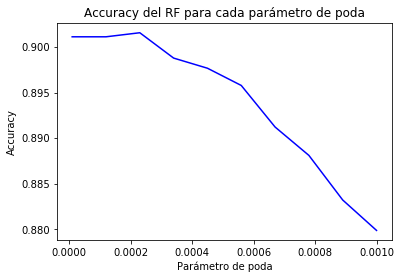

In [120]:
grafica(np.linspace(0.00001, 0.001, num=10), accuracy, 'Accuracy del RF para cada parámetro de poda', 'Parámetro de poda', 'Accuracy')

In [121]:
accuracy

[0.9011123470522804,
 0.9011123470522804,
 0.9015572858731924,
 0.8987764182424918,
 0.8976640711902114,
 0.8957730812013349,
 0.8912124582869854,
 0.8880978865406007,
 0.8832035595105673,
 0.8798665183537263]

Modelo final:

In [122]:
# Vectores con los valores de las métricas
rf_clf = RandomForestClassifier(random_state=15, n_estimators=220, criterion = "entropy", ccp_alpha= 0.00023)
score = cross_val_score(rf_clf, data, target, cv=5)

s = 0
for i in range(len(score)):
    s+= score[i]

print("La accuracy del modelo es: " + str(s/len(score)))

La accuracy del modelo es: 0.9015572858731924


## Predicción del test

Procesamos los datos de test de la misma manera que procesamos los de entrenamiento

In [123]:
p1_test = test.copy()
del(p1_test['Descuento'])
p1_test = p1_test.dropna()
p1_test = p1_test.reset_index()
del(p1_test['index'])
p1_test

,id,Nombre,Ciudad,Año,Kilometros,Combustible,Tipo_marchas,Mano,Consumo,Motor_CC,Potencia,Asientos
0,4820,Mercedes-Benz New C-Class C 220 CDI Avantgarde,H,2015,77771,Diesel,Automatic,First,19.27 kmpl,2143 CC,170 bhp,5.0
1,4821,Hyundai i10 Magna 1.1,J,2011,62000,Petrol,Manual,First,19.81 kmpl,1086 CC,68.05 bhp,5.0
2,4822,Ford Figo Diesel EXI,C,2010,129986,Diesel,Manual,Second,20.0 kmpl,1399 CC,68 bhp,5.0
3,4823,Maruti Swift Dzire VXI Optional,D,2015,49900,Petrol,Manual,First,20.85 kmpl,1197 CC,83.14 bhp,5.0
4,4824,Maruti Ritz VXI,J,2010,75319,Petrol,Manual,Second,21.1 kmpl,1197 CC,85.80 bhp,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1154,5974,Chevrolet Beat Diesel LT,G,2012,88000,Diesel,Manual,First,25.44 kmpl,936 CC,57.6 bhp,5.0
1155,5975,Hyundai Verna CRDi,K,2010,72010,Diesel,Manual,First,16.8 kmpl,1493 CC,110 bhp,5.0
1156,5976,Mercedes-Benz A Class A180 CDI,J,2013,34000,Diesel,Automatic,Second,20.0 kmpl,2143 CC,107.3 bhp,5.0
1157,5977,BMW X1 M Sport sDrive 20d,B,2016,31000,Diesel,Automatic,First,17.05 kmpl,1995 CC,190 bhp,5.0


Nombre:

In [124]:
p1_test.Nombre = labelNombre.transform(p1_test.Nombre)

Ciudad:

In [125]:
p1_test.Ciudad = labelCiudad.transform(p1_test.Ciudad)

Combustible:

In [126]:
p1_test.Combustible = labelCombustible.transform(p1_test.Combustible)

Tipo_marchas:

In [127]:
p1_test.Tipo_marchas = labelTipo_marchas.transform(p1_test.Tipo_marchas)

Mano:

In [128]:
p1_test.Mano = labelMano.transform(p1_test.Mano)

Consumo:

In [129]:
for i in range(len(p1_test)):
    p1_test["Consumo"].iloc[i] = float(p1_test["Consumo"].iloc[i].strip(' kmlp'))

/home/patricia/.local/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Motor_CC:

In [130]:
for i in range(len(p1_test)):
    p1_test["Motor_CC"].iloc[i] = float(p1_test["Motor_CC"].iloc[i].strip(' CC'))

Potencia:

In [131]:
for i in range(len(p1_test)):
    p1_test["Potencia"].iloc[i]= float(p1_test["Potencia"].iloc[i].strip(' bhp'))

In [132]:
ids = p1_test['id']
del(p1_test['id'])

In [133]:
# Vectores con los valores de las métricas
rf_clf = RandomForestClassifier(random_state=15, n_estimators=220, criterion = "entropy", ccp_alpha= 0.00023)
rf_clf.fit(data, target)
predict = rf_clf.predict(p1_test)

In [134]:
df_result = pd.DataFrame({'id': ids, 'Precio_cat': predict})
df_result.to_csv("p3_01.csv", index=False)

In [135]:
predict = pd.read_csv("p3_01.csv", na_values=["?"])

In [136]:
predict

,id,Precio_cat
0,4820,5
1,4821,2
2,4822,2
3,4823,3
4,4824,2
...,...,...
1154,5974,2
1155,5975,3
1156,5976,5
1157,5977,5
